# Condensation flux

In this notebook, I compute the condensation and evaporation dynamics near a fungal patch. Specifically, I look at the evolution of the droplet radii and the condensation flux obtained from experiment. The input data is the droplet detection (table of [x,y,r], described in the bubble detection notebook). 

The droplet radii evolution is contrasted with the theory in the book by Beysens (2023). The condensation flux is contrasted with the model in [Jung 2021](https://pubs.acs.org/doi/10.1021/acs.langmuir.1c00473).

## 0 Packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks
plt.rcParams['ytick.major.size'] = 2  # Length of major ticks
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks
import cv2
import shutil
from myimagelib.myImageLib import readdata
import pandas as pd
from skimage import io

## 1 Total volume and flux

We detect the droplets using a combined approach of OpenCV algorithm and hand correction, which gives us the starting point of calculations in this section: droplet locations and sizes recorded in .csv files with columns [x, y, r]. Calibration and frame rate are needed to convert the data from experiment units (px, frame) to physical units (mm, min). 

Here, I propose the data folder structure as the following:

```
date\
    tracking\
        exp1\ (video file name)
            0000.csv (xyr data)
            0001.csv
            ...
            fps_mpp.txt (calibration information)
    exp1.avi
```

Always read raw data and make plots. 

In this section, we plot the droplet total volume vs. time in distance bins. This first requires dividing the droplet size data based on distances between each droplet and the center of the fungal patch. This dividing process is illustrated below.

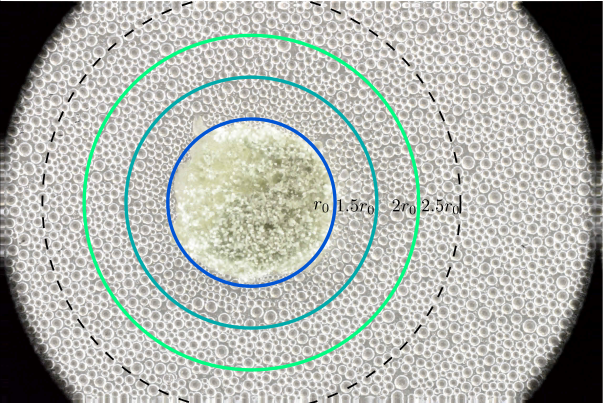

Here, the droplet size and location data are represented as `pd.DataFrame`s of [x,y,r]. Each DataFrame is a snapshot at a time. The time is indicated by the names of the files that store the DataFrames, with unit frame. We will take the following steps to process our data into the final forms (volume-time, flux-time, flux-distance):

1. Read the calibration data measured from experiment: fps, mpp, x0, y0, r0;
2. Choose the distance bins to analyze the data. The bin is typically characterized by the bounds and number of bins;
3. Compute the distances from the fungal patch center $R$ and append to the original [x,y,r] table;
4. Divide the droplets into distance bins and compute the total volume of each bin;
5. Once all the time steps are computed, we can construct a table of volume, with one axis being distance, the other being the time:
    ```
        R1  R2  R3
    t1  ..
    t2      ..
    t3          ..
    ```
6. We can construct flux table by performing `diff()` in time, and then divide it by the corresponding area. 
   Note: the calculation of area depends on the image. For example, in the zoom-out view we calculate the area of annular rings, whereas in the zoom-in view we calculate the area of partial rings cropped by the rectangular frames.
7. Unit conversion 
8. Plot volume-time and flux-time at various distances, and flux-distance at various time. 

In the following, let's implement it step by step.

In [206]:
# set up the parameters
folder = r"G:\My Drive\Research projects\F\Data\02202025\exp2"

### 1.1 Analyze the folder content

The folder should contain image files (.jpg), tracking data files (.csv), and experiment info files (.txt). The tracking data files is a subset of the image files, as some images are impossible to analyze. Images are named with consecutive integers, so it is important to infer the $t_0$ from the image files. 

In [207]:
# Step 1.1 read calibration data
with open(os.path.join(folder, "fps_mpp.txt")) as f:
    fps = float(f.readline().strip().split(":")[1])
    mpp = float(f.readline().strip().split(":")[1])
    x0, y0, r0 = [int(i) for i in f.readline().strip().split(":")[1].split(",")]
print(f"fps: {fps:.2f} \nmpp: {mpp:.1f} um/px \ncenter: {x0:d}, {y0:d} \nradius: {r0:d}")

fps: 0.10 
mpp: 0.8 um/px 
center: -927, 1312 
radius: 1973


In [208]:
# Step 1.2 Infer t0
l = readdata(os.path.join(folder), "jpg")
img = io.imread(l.Dir[0])
h, w = img.shape[:2]
print(f"{len(l)} images found")
imgNum = [int(name[3:]) for name in l.Name]
imgNum = np.array(imgNum)
t0 = imgNum.min()
print(f"t0 = {t0}")
l = readdata(os.path.join(folder), "csv")
print(f"{len(l)} data files found")
frameNum = [int(name[3:]) for name in l.Name]
frameNum = np.array(frameNum)
frameNum = frameNum - t0
t = frameNum / fps / 60

184 images found
t0 = 73164
108 data files found


### 1.2 Overall statistics

In [209]:
l = readdata(os.path.join(folder), "csv")

In [210]:
radii = []
nDrops = []
for num, i in l.iterrows():
    xyr = pd.read_csv(i.Dir)
    radii.append(xyr.r.mean()*mpp)
    nDrops.append(len(xyr))

Text(0.5, 0, 'Time (min)')

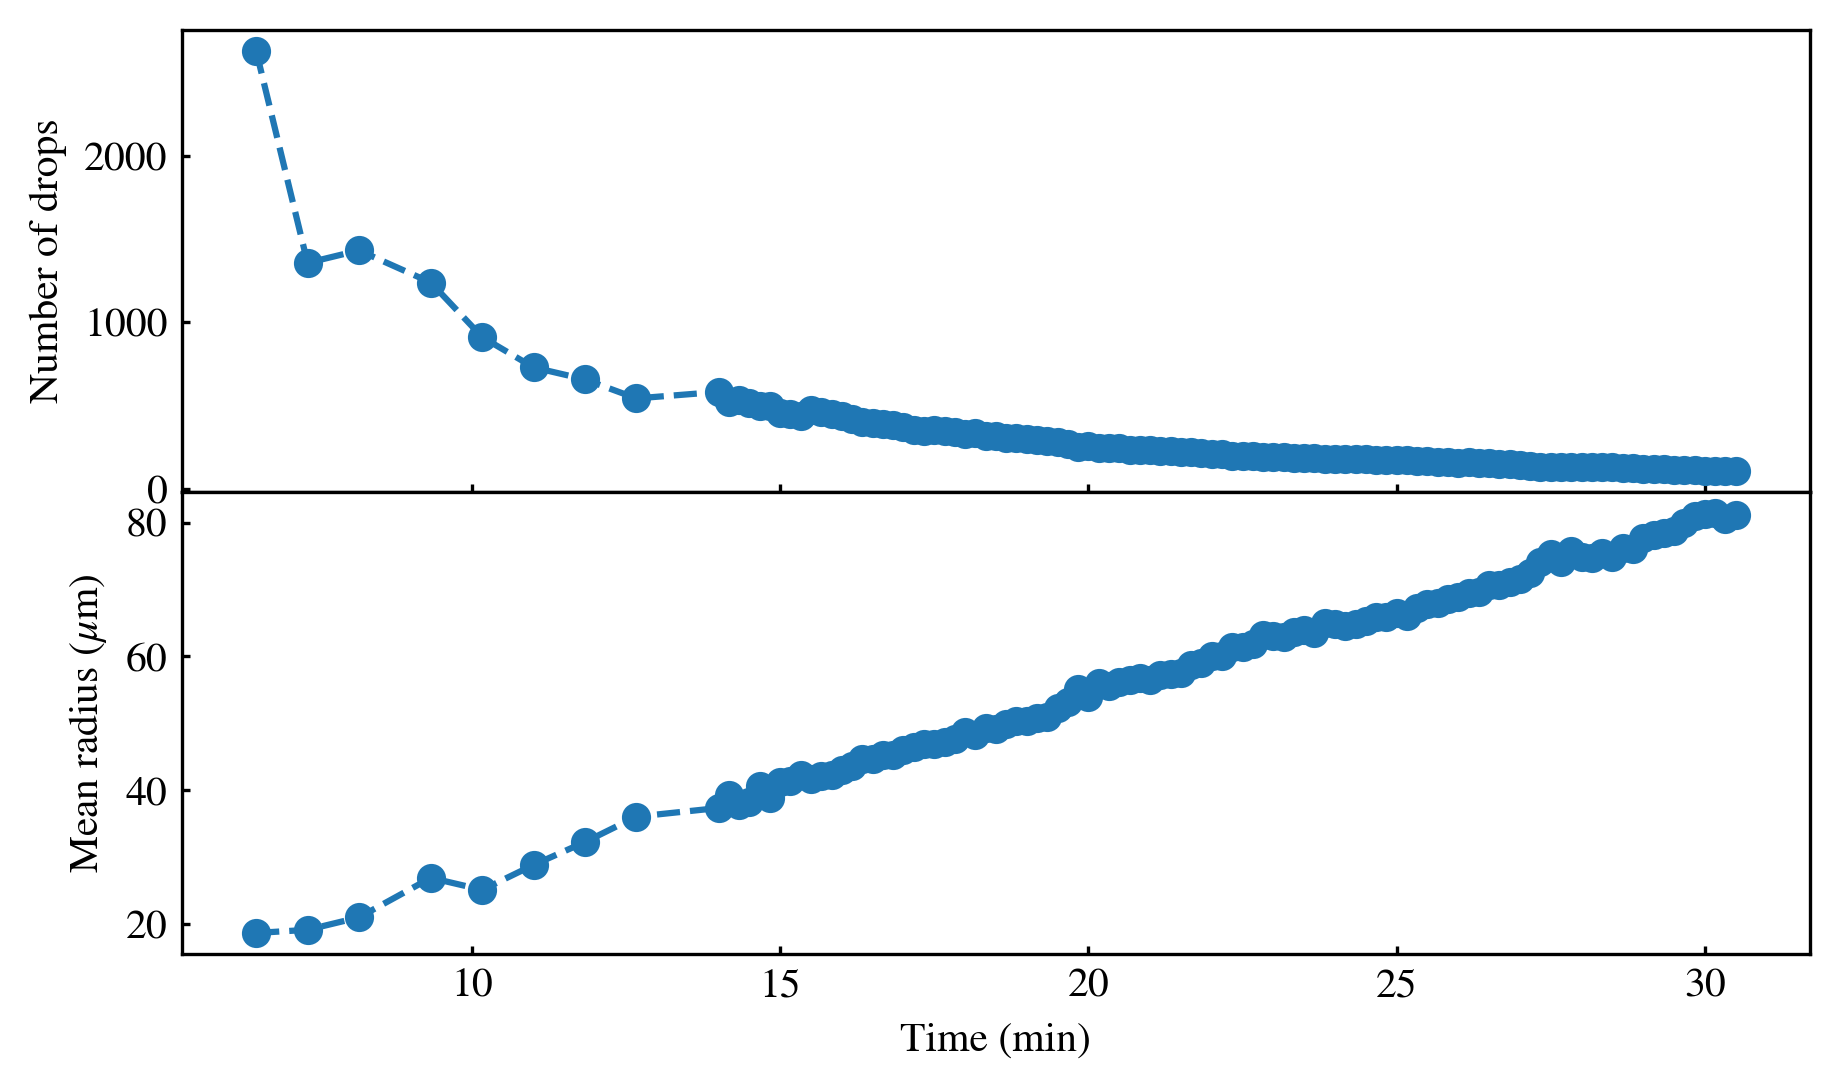

In [211]:
fig, ax = plt.subplots(nrows=2, figsize=(7, 4), dpi=300, sharex=True, gridspec_kw={"hspace": 0})
ax[0].plot(t, nDrops, ls="--", marker="o")
ax[0].set_ylabel("Number of drops")
ax[1].plot(t, radii, ls="--", marker="o")
ax[1].set_ylabel("Mean radius ($\mu$m)")
ax[1].set_xlabel("Time (min)")

### 1.3 Choose distance bins

In [212]:
bins

array([2170.3 , 2683.28, 3196.26, 3709.24, 4222.22, 4735.2 ])

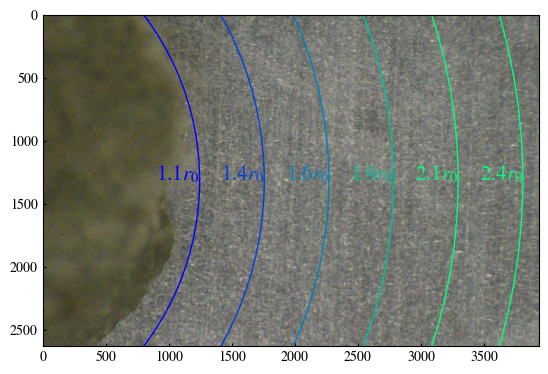

In [213]:
# Step 2. choose distance bins
bounds = [r0*1.1, 2.4*r0]
nBins = 5
bins = np.linspace(bounds[0], bounds[1], nBins+1)
cmap = plt.get_cmap("winter")
# visualize the bins
l = readdata(folder, "jpg")
plt.imshow(img)
for i, r in enumerate(bins):
    circle = plt.Circle((x0, y0), r, color=cmap(i/(nBins-1)), fill=False)
    # annotate distance
    plt.annotate(f"{r/r0:.1f}$r_0$", (x0+r, y0), color=cmap(i/(nBins-1)), fontsize=15, horizontalalignment="right")
    plt.gca().add_artist(circle)

### 1.4 Compute the distance from the fungal patch center

In [ ]:
l = readdata(folder, "csv")
distance_bin_data = {}
for j in range(nBins):
    distance_bin_data[j] = []
for num, i in l.iterrows():
    xyr = pd.read_csv(i.Dir)
    xyr["R"] = ((xyr.x - x0)**2 + (xyr.y - y0)**2) ** 0.5
    # Step 4. divide droplets into bins and compute the volume of drops in each bin
    for j in range(nBins):
        sub_xyr = xyr.loc[(xyr.R > bins[j]) & (xyr.R <= bins[j+1])]
        volume_bin = 2/3 * np.pi * (sub_xyr.r**3).sum()
        distance_bin_data[j].append(volume_bin)

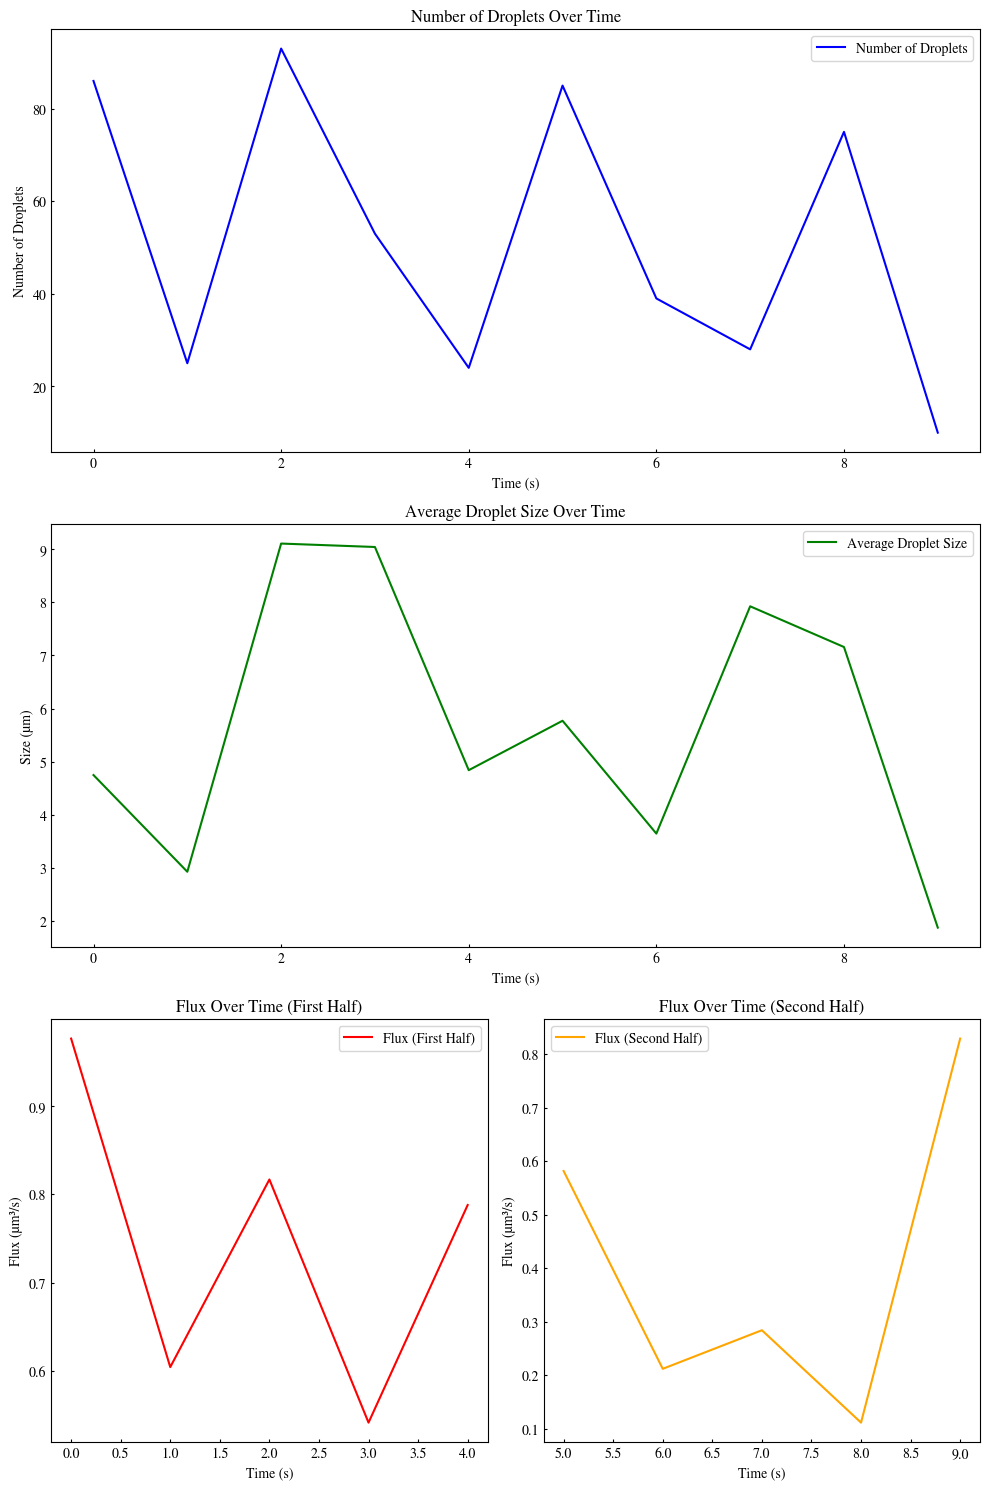

In [4]:
# Create subplots
fig = plt.figure(figsize=(10, 15))

t = np.arange(10)
N = np.random.randint(1, 100, size=10)  # Example data for number of droplets
S = np.random.uniform(1, 10, size=10)  # Example data for average droplet size
flux = np.random.uniform(0, 1, size=10)  # Example data for flux
# Plot number of droplets over time
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(t, N, label="Number of Droplets", color="blue")
ax1.set_title("Number of Droplets Over Time")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Number of Droplets")
ax1.legend()

# Plot average droplet size over time
ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(t, S, label="Average Droplet Size", color="green")
ax2.set_title("Average Droplet Size Over Time")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Size (µm)")
ax2.legend()

# Divide axs[2] into two axes
axs2_1 = fig.add_subplot(3, 2, 5)  # First half
axs2_2 = fig.add_subplot(3, 2, 6)  # Second half

# Plot flux for the first half
axs2_1.plot(t[:len(t)//2], flux[:len(flux)//2], label="Flux (First Half)", color="red")
axs2_1.set_title("Flux Over Time (First Half)")
axs2_1.set_xlabel("Time (s)")
axs2_1.set_ylabel("Flux (µm³/s)")
axs2_1.legend()

# Plot flux for the second half
axs2_2.plot(t[len(t)//2:], flux[len(flux)//2:], label="Flux (Second Half)", color="orange")
axs2_2.set_title("Flux Over Time (Second Half)")
axs2_2.set_xlabel("Time (s)")
axs2_2.set_ylabel("Flux (µm³/s)")
axs2_2.legend()

# Adjust layout to accommodate the new axes
plt.tight_layout()
axs[2].plot(t, flux, label="Flux", color="red")
axs[2].set_title("Flux Over Time")
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Flux (µm³/s)")
axs[2].legend()

### 1.5 Construct volume and table

frame, volume1, volume2, ...

In [215]:
# Step 5. construct volume table
volume_pxf = pd.DataFrame(data=distance_bin_data, index=frameNum)

In [ ]:
# Step 6. construct flux table, note that the calculation of area varies with image
dr = bins[1:] - bins[:-1]
# area =  2 * np.pi * bins[:-1] * dr # annulus area
area = h * dr # rectangular area
flux_pxf = volume_pxf.diff().div(volume_pxf.index.to_series().diff().values, axis=0).div(area, axis=1)

In [217]:
# Step 7. convert units and plot the results
# We use the following conversion factors for volume and flux
# volume: px^3 -> x mpp^3 x 1e-9 -> mm^3
# flux: px/s -> x mpp x 1e-3 x fps x 60 -> mm/min
volume = volume_pxf * mpp**3 * 1e-9
flux = flux_pxf * mpp * 1e-3 * fps * 60
flux["t"] = flux.index / fps / 60
volume["t"] = volume.index / fps / 60

### 1.6 Plot volume, flux and flux vs. distance

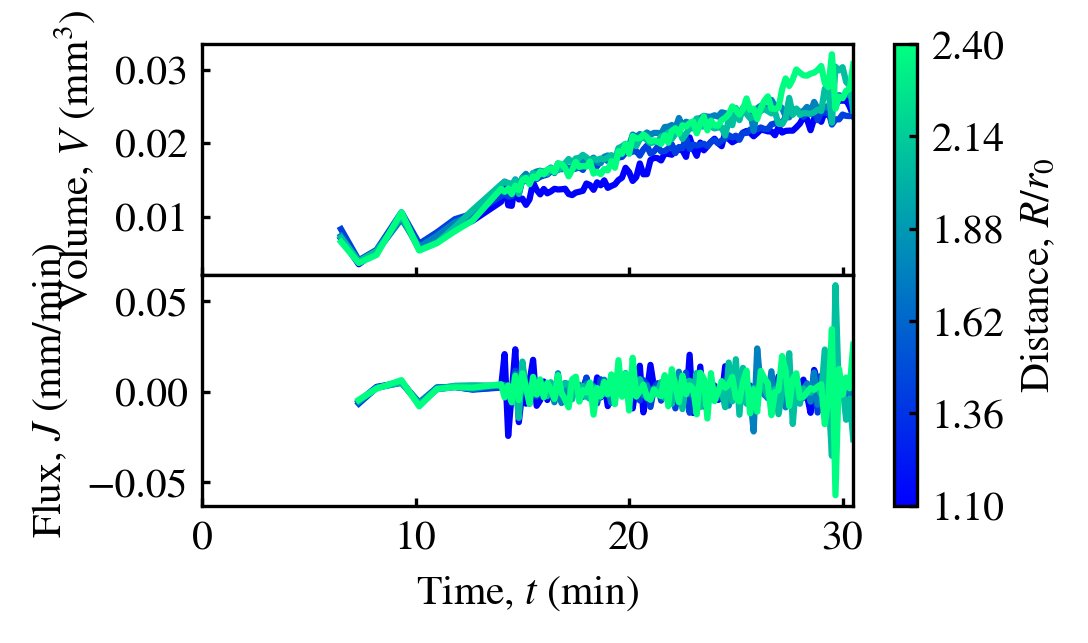

In [218]:
# Step 8. plot the results
## volume and flux vs. time
fig, ax = plt.subplots(nrows=2, figsize=(3.5, 2), dpi=300, sharex=True, gridspec_kw={"hspace": 0})
cmap = plt.get_cmap("winter")
for kw in volume.drop(columns="t"):
    ax[0].plot(volume["t"], volume[kw], color=cmap(kw/(nBins-1)))
    ax[1].plot(flux["t"], flux[kw], color=cmap(kw/(nBins-1)))
ax[0].set_xlim([0, volume["t"].max()])
ax[0].set_ylabel("Volume, $V$ (mm$^3$)")
ax[1].set_ylabel("Flux, $J$ (mm/min)")
ax[1].set_xlabel("Time, $t$ (min)")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(bins[0]/r0, bins[-1]/r0))
cbar = plt.colorbar(sm, ax=ax, label="Distance, $R/r_0$")
cbar.set_ticks(bins/r0)

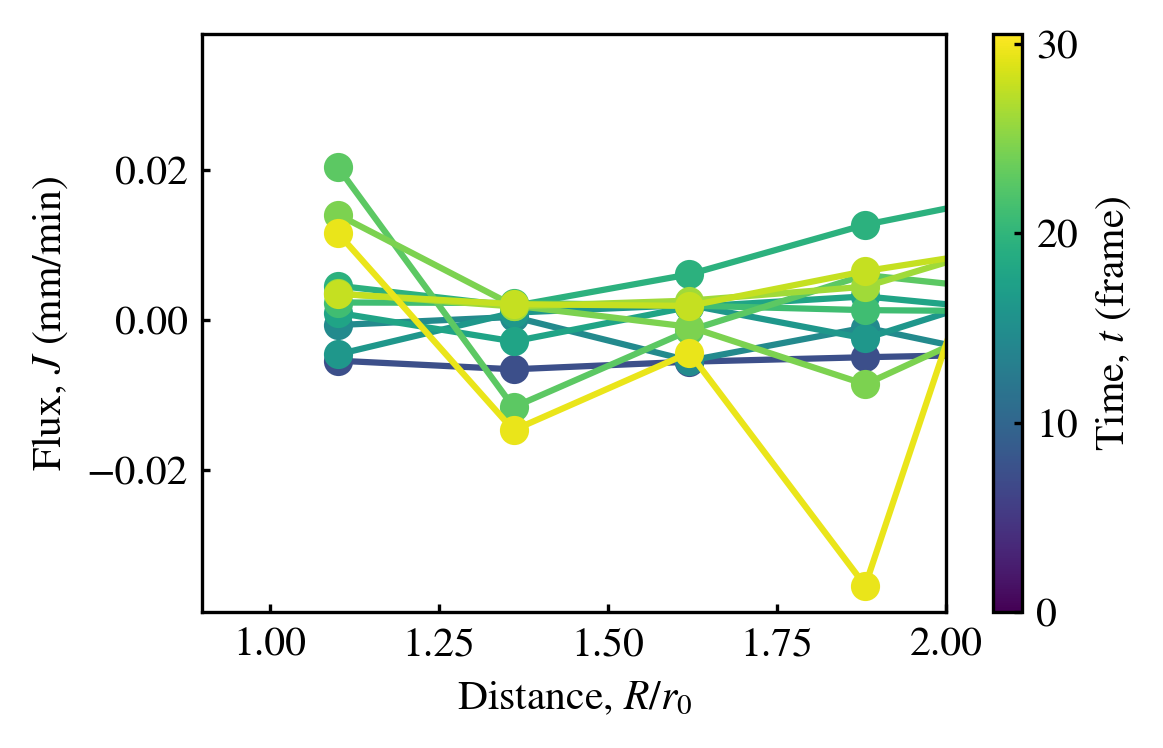

In [220]:
# Step 8. plot the results
## 8.2 flux vs. distance
## An annotated image indicating the distance bins is shown as inset
sparsity = 10
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=300)
cmap = plt.get_cmap("viridis")
tmax = flux.t.max()
t_list = []
# main plot
for frame, i in flux.dropna()[::sparsity].iterrows():
    ax.plot(bins[:-1]/r0, i.drop("t"), marker="o", color=cmap(i.t/tmax))
ax.set_xlabel("Distance, $R/r_0$")
ax.set_ylabel("Flux, $J$ (mm/min)")
ax.set_xlim([0.9, 2])
# ax.set_ylim([-.01, 0.01])
# ax.set_yticks([-0.01, 0, 0.01])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, tmax))
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Time, $t$ (frame)")
# inset
# cmap = plt.get_cmap("winter")
# img = cv2.imread(os.path.join(folder, "blob", "0060.jpg"))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# for j in range(nBins):
#     cv2.circle(img, (x0, y0), int(bins[j]), tuple(int(round(c*255)) for c in cmap(j/(nBins-1))[:3]), 30)
# ax_inset = inset_axes(ax, width="40%", height="40%", loc='upper right',
#                       bbox_to_anchor=(0,0, 1.0, 1.0),
#                       bbox_transform=ax.transAxes,
#                       borderpad=0)
# ax_inset.imshow(img)
# ax_inset.axis("off")

Theoretically, the vapor flux towards the cold surface is a constant, provided that the vapor pressure gradient is a constant. In that case, the increase of water volume in each distance band should be at a constant rate. The time derivative of the volume is a little noisy. To improve the data, we can fit the volume in the condensation stage with a linear line, and then extract the constant flux. 

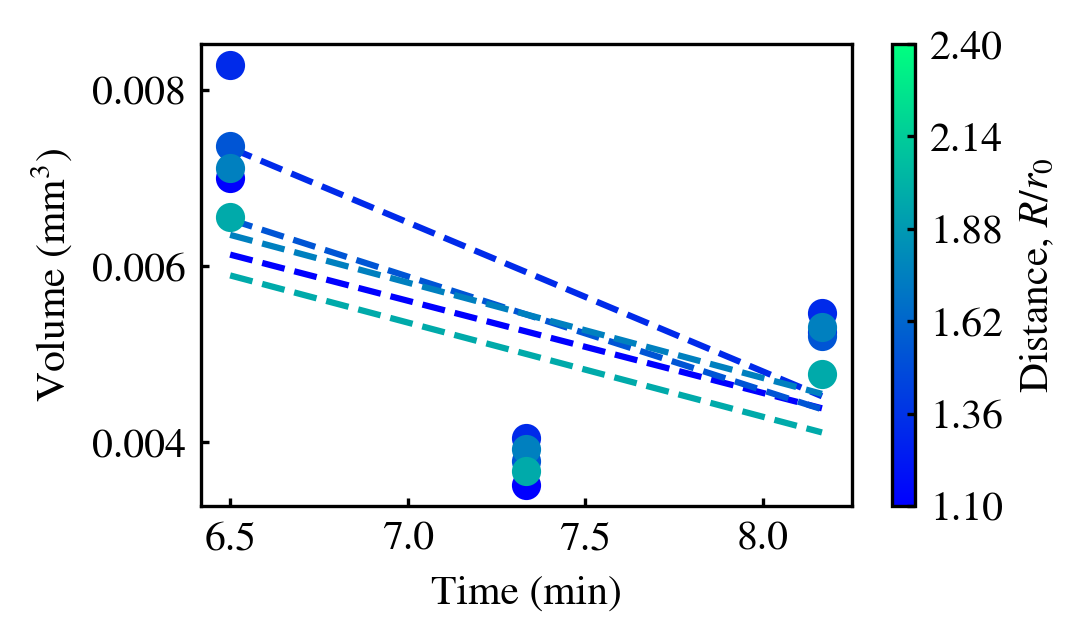

In [231]:
fig, ax = plt.subplots(figsize=(3.5, 2), dpi=300, sharex=True, gridspec_kw={"hspace": 0})
cmap = plt.get_cmap("winter")
p_list = []
for i in range(volume.drop(columns="t").shape[1]):
    x, y =volume.t[:3], volume.iloc[:3, i]
    p = np.polyfit(x, y, 1)
    p_list.append(p)
    plt.plot(x, y, "o", color=cmap(i/volume.shape[1]))
    plt.plot(x, np.polyval(p, x), color=cmap(i/volume.shape[1]), ls="--")
plt.ylabel("Volume (mm$^3$)")
plt.xlabel("Time (min)")
# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(bins[0]/r0, bins[-1]/r0))
cbar = plt.colorbar(sm, ax=ax, label="Distance, $R/r_0$")
cbar.set_ticks(bins/r0)

The linear lines fit the data pretty well. Next, we extract the slopes $\mathrm{mm^3/min}$ and convert it to flux.

In [232]:
p_list

[array([-0.00104763,  0.01294337]),
 array([-0.00169332,  0.01835348]),
 array([-0.00129333,  0.01493899]),
 array([-0.00108388,  0.01340339]),
 array([-0.00107041,  0.01285506])]

In [233]:
flux_r = np.array(p_list)[:, 0] / (2*np.pi*bins[:-1]*dr*mpp*1e-6)

Text(0, 0.5, 'Flux (mm/min)')

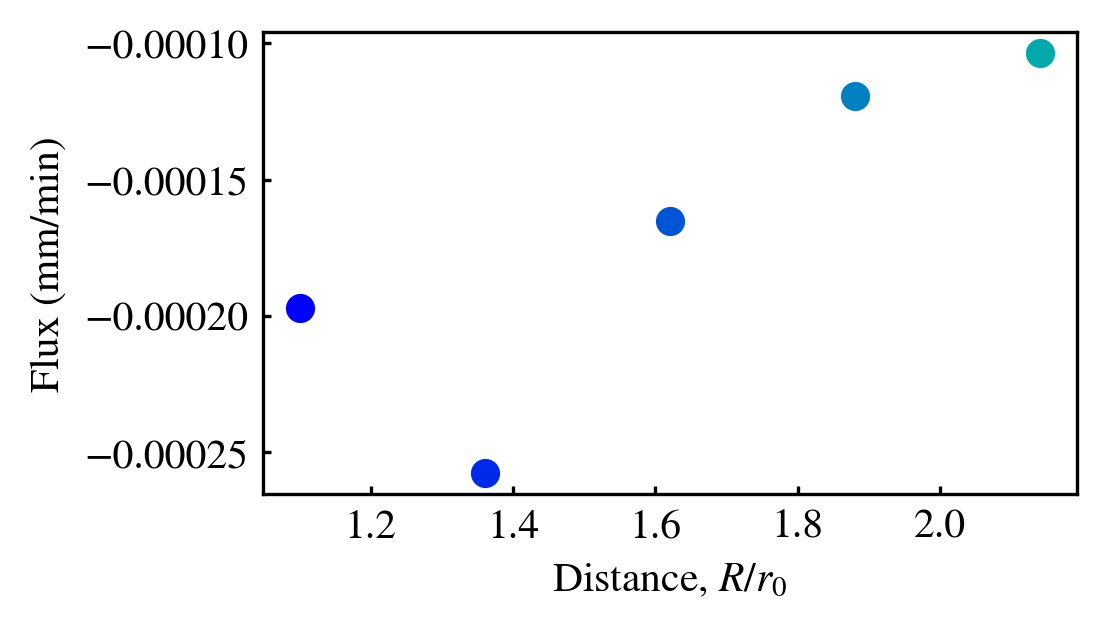

In [234]:
# plot flux as a function of distance
fig, ax = plt.subplots(figsize=(3.5, 2), dpi=300)
cmap = plt.get_cmap("winter")
for i, p in enumerate(flux_r):
    ax.plot(bins[i]/r0, flux_r[i], "o-", color=cmap(i/volume.shape[1]))
ax.set_xlabel("Distance, $R/r_0$")
ax.set_ylabel("Flux (mm/min)")

# Appendix

## A. Extract hand labeling data

In [43]:
# I have a folder, in which there are subfolders containing images, detection and information text files
# I want to read the information text files and save the frame number information to a list

folder = r"G:\My Drive\Research projects\F\Data\hand_labeling_data"
save_folder = r"G:\My Drive\Research projects\F\Data\06282024\tracking"
tar_date = "062824"
tar_title = "exp5.mp4"

os.makedirs(save_folder, exist_ok=True)
sfL = next(os.walk(folder))[1]

frame_list = []
for sf in sfL: 
    data_path = os.path.join(folder, sf, "info.txt")
    with open(data_path, "r") as f:
        lines = f.readlines()
        date = lines[0].strip().split(":")[-1].strip()
        title = lines[1].strip().split(":")[-1].strip()
        if date == tar_date and title == tar_title:
            frame_number = int(lines[2].strip().split(":")[-1])
            prelim_file = os.path.join(folder, sf, "prelim_detection.csv")
            hand_file = os.path.join(folder, sf, "hand.csv")
            if os.path.exists(hand_file):
                shutil.copy(hand_file, os.path.join(save_folder, f"{frame_number:04d}.csv"))
            else:
                shutil.copy(prelim_file, os.path.join(save_folder, f"{frame_number:04d}.csv"))

## B. Total volume decreases during condensation



## C. Illustrate droplet growth

In [ ]:
# draw a few concentric hemisphere with different radii, color them using viridis colormap

def create_semicircle(radius, num_points=100):
    theta = np.linspace(0, np.pi, num_points)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    return x, y

# Step 3: Generate multiple semicircles with different radii
radii = [1, 2, 3, 4, 5]
colors = plt.get_cmap("Blues", 10)

# Step 4: Use the Viridis colormap to color the semicircles
fig, ax = plt.subplots(dpi=300)
i = 3
for radius in radii:
    x, y = create_semicircle(radius)
    ax.plot(x, y, color=colors(i))
    i += 1

# Step 5: Plot the semicircles using matplotlib
ax.set_aspect('equal')
ax.axis('off')

# generate colorbar



In [169]:
# extract [900, 1800, 2700, 3600] frames from a video file
def get_frame_from_video(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError(f"Could not read frame {frame_number}")
    return frame

folder = r"F:\F\10082024"
filename = "exp1_cpndensation.MOV"
fns = [9000, 18000, 27000, 30000]
for frame_number in fns:
    video_path = os.path.join(folder, filename)
    frame = get_frame_from_video(video_path, frame_number)
    cv2.imwrite(os.path.join(folder, f"{frame_number:04d}.jpg"), frame)

## D. Theory: single semi-sphere and semi-cylinder

The model predicts the condensation flux near a bump on a flat surface. The condensation on the bump is currently inaccessible from experiment, so we focus on the flux outside the bump on the flat surface. 

Near a semi-spherical bump, the flux outside the bump is modeled as

$$
J_{cylinder} = 1 - \frac{r^3}{x^3},
$$

where $x$ is the distance from the fungal patch center and $r$ is the radius of the fungal patch. 

Note that the fluxes are all relative to the flux in a canonical case where condensation happens on a pure flat surface. 

In [ ]:
r = 1 # radius of the circle
x = np.linspace(r, 4*r, 100)
J = 1 - r**3 / x**3

fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=300)
ax.plot(x, J)

ax.set_xlabel("$x/r$")
ax.set_ylabel("$J$")
ax.legend(frameon=False)
ax.set_xlim(0, 4*r)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.savefig("flux_around_a_bump.pdf")

## E. Detected droplet overlay

In [236]:
#### set parameters ####
folder = r"G:\My Drive\Research projects\F\Data\02202025\exp2"
dpi = 300
########################
save_folder = os.path.join(folder, "overlay")
os.makedirs(save_folder, exist_ok=True)

l = readdata(folder, "jpg")
img = io.imread(l.Dir[0])
h, w = img.shape[:2]
for num, i in l.iterrows():
    if os.path.exists(os.path.join(save_folder, f"{i.Name}.jpg")):
        continue
    data_path = os.path.join(folder, f"{i.Name}.csv")
    img = io.imread(i.Dir)
    plt.figure(figsize=(w/dpi,h/dpi), dpi=dpi)
    plt.imshow(img)
    plt.axis("off")
    try:
        drops = pd.read_csv(data_path)
        for _, drop in drops.iterrows():
            x, y, r = drop[["x", "y", "r"]].astype(int)
            circle = plt.Circle((x, y), r, color='yellow', fill=False, linewidth=2)
            plt.gca().add_artist(circle)
    except:
        pass

    # save image
    plt.savefig(os.path.join(save_folder, f"{i.Name}.jpg"), bbox_inches="tight", pad_inches=0)
    plt.close()